#  Indian Air Quality Index (IND-AQI)

* AQI India provides air pollution data with real-time Air Quality Index(AQI). Air quality standards are the basic foundation that provides a legal framework for air pollution control. An air quality standard is a description of a level of air quality that is adopted by a regulatory authority as enforceable. The basis of development of standards is to provide a rational for protecting public health from adverse effects of air pollutants, to eliminate or reduce exposure to hazardous air pollutants, and to guide national/ local authorities for pollution control decisions
* So Central Pollution Control Board notified a new set of Indian National Air Quality Standards(INAQS) for 12 parameters: carbon monoxide (CO) nitrogen dioxide (NO2), sulphur dioxide (SO2), particulate matter (PM) of less than 2.5 microns  size  (PM2.5),  PM  of  less  than  10  microns  size  (PM10),  Ozone  (O3),  Lead  (Pb),  Ammonia  (NH3), Benzo(a)Pyrene (BaP), Benzene (C6H6), Arsenic (As), and Nickel (Ni)
* Bap3, C4H6, As and Ni have annual standards




# Indian National Air Quality Standards (units: μg/m3 unless mentioned otherwise)
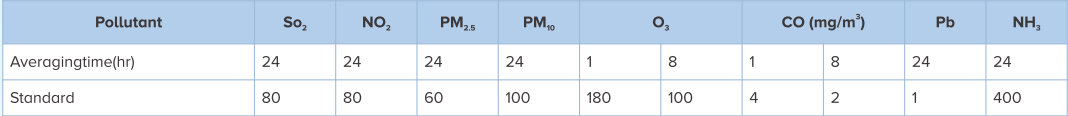

* It is recognized that air concentrations of Pb are not known in real-time and cannot contribute to real-time AQI 

*  To  present  status  of  the  air  quality  and  its  effects  on  human  health,  the  following description categories have been adopted for IND-AQI 

* IND-AQI Category and Range

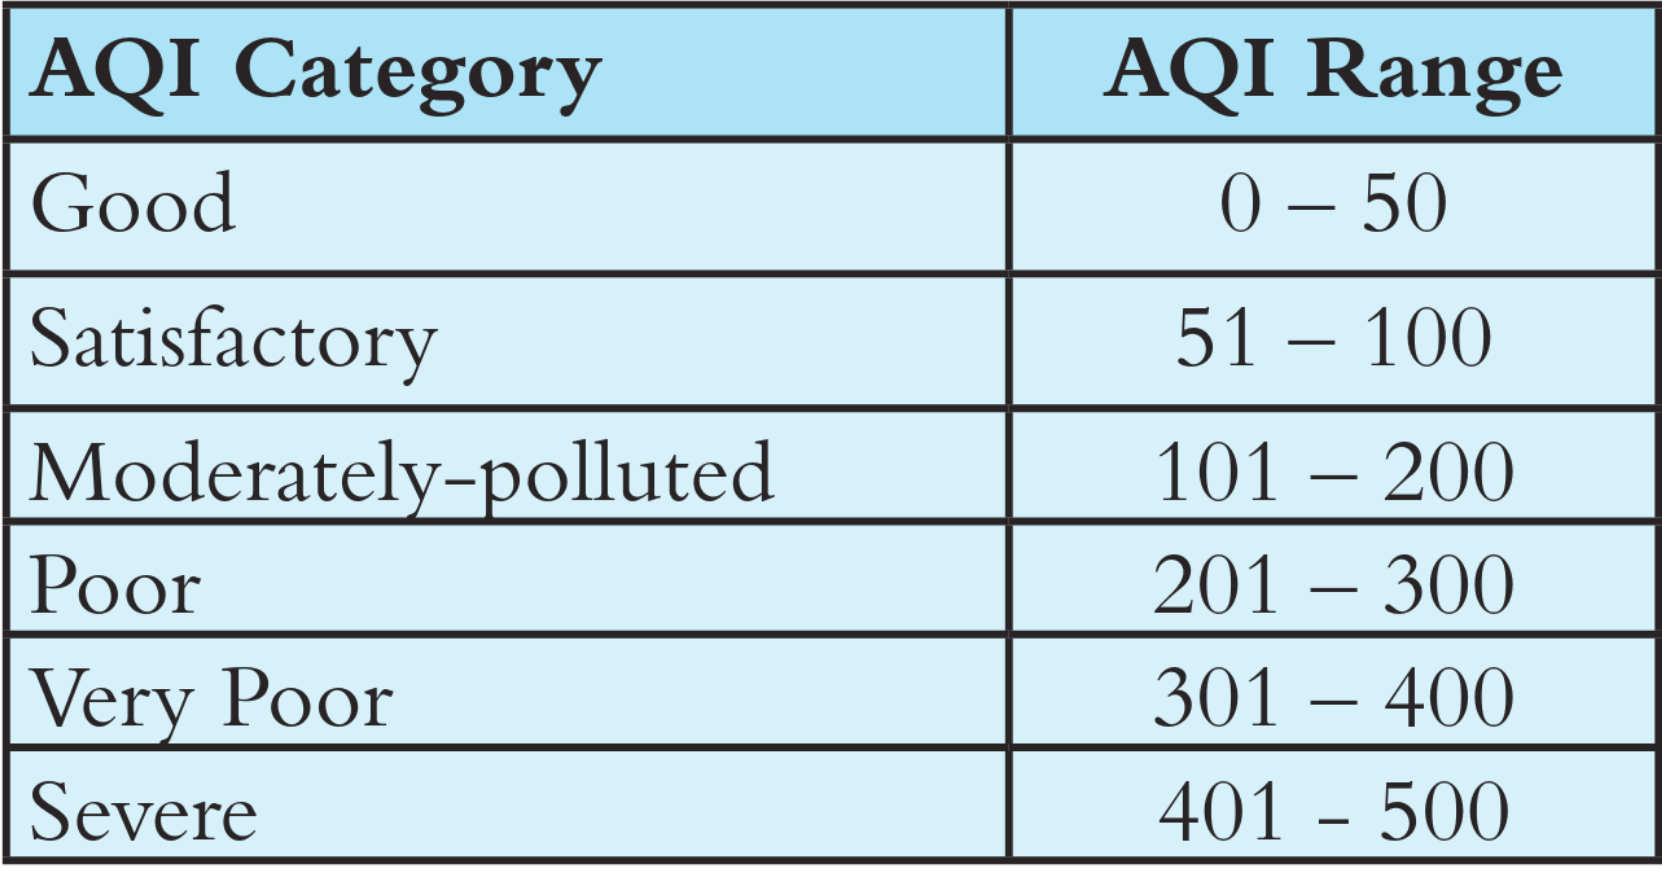

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import warnings
from math import pi
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [ ]:
# Missing values
def missing_values(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n""There are " + str(mis_val_table_ren_columns.shape[0]) +" columns that have missing values.")
        

        return mis_val_table_ren_columns.style.background_gradient(cmap='Reds')


In [ ]:
df_station_hour = pd.read_csv("/kaggle/input/air-quality-data-in-india/station_hour.csv", parse_dates = ["Datetime"] )
df_city_hour    = pd.read_csv("/kaggle/input/air-quality-data-in-india/city_hour.csv")
df_station_day  = pd.read_csv("/kaggle/input/air-quality-data-in-india/station_day.csv")
df_city_day     = pd.read_csv("/kaggle/input/air-quality-data-in-india/city_day.csv")
df_stations     = pd.read_csv("/kaggle/input/air-quality-data-in-india/stations.csv")

# Data analysis

* Let's find how the AQI index categories are named

In [ ]:
df_city_hour.head()

In [ ]:
np.unique(df_city_hour['AQI_Bucket'][df_city_hour['AQI_Bucket'].notnull()].values)

# ->
* The AQI bins are named as they are defined in the IND-AQI Category and Range

In [ ]:
df_stations.head()

# ->
* Let's assess each state information

In [ ]:
grouped=df_stations.groupby(['State'])
for name,group in grouped:
    print( name)
    print('-'*30)
    print( np.unique(group['City']),'\n\n')
    

# ->
* Now let's seperate data of one station and work on it

In [ ]:
Amaravati=['AP001'] 

In [ ]:
df =df_station_hour



df = df[df.StationId.isin(Amaravati)]
df.sort_values(["StationId", "Datetime"], inplace = True)
df["Date"] = df.Datetime.dt.date.astype(str)
df.Datetime = df.Datetime.astype(str)

In [ ]:
df

In [ ]:
missing_values(df)

# -> calculating AQI index
* The AQI index is calculated by using mathematical relation.
* first the raw data is grouped into 24 hours and average is taken for each pollutant concentration, 8 hours in case of co and o3.
* now the sub index of each pollution is calculatd.
* The aggrregated AQI indesx is calculated by using various methods but to avoid over estimation(Ambiguos values) and under estimation (eclipse values) the maximum of values is used to calculate final AQI index.


# step 1

# ->
* The averages are calculated according to Indian National Air Quality Standards

In [ ]:
df["PM10_24hr_avg"] = df.groupby("StationId")["PM10"].rolling(window = 24, min_periods = 16).mean().values
df["PM2.5_24hr_avg"] = df.groupby("StationId")["PM2.5"].rolling(window = 24, min_periods = 16).mean().values
df["SO2_24hr_avg"] = df.groupby("StationId")["SO2"].rolling(window = 24, min_periods = 16).mean().values
df["NOx_24hr_avg"] = df.groupby("StationId")["NOx"].rolling(window = 24, min_periods = 16).mean().values
df["NH3_24hr_avg"] = df.groupby("StationId")["NH3"].rolling(window = 24, min_periods = 16).mean().values
df["CO_8hr_max"] = df.groupby("StationId")["CO"].rolling(window = 8, min_periods = 1).max().values
df["O3_8hr_max"] = df.groupby("StationId")["O3"].rolling(window = 8, min_periods = 1).max().values

# step 2

# ->
* calculating the sub indices of each individual pollutant
* the formula to calculte the sub index of a pollutant at a given concentration is:
# Isub = ({(IHI - ILO)/(BHI -BLO)} * (Cp-BLO))+  ILO
* BHI= Breakpoint concentration greater or equal to given concentration.
* BLO= Breakpoint concentration smaller or equal to given concentration.
* IHI =AQI value corresponding to BHI
* ILO = AQI value corresponding to BLO
* Cp = Pollutant concentration
* AQI ranges are given in the above table

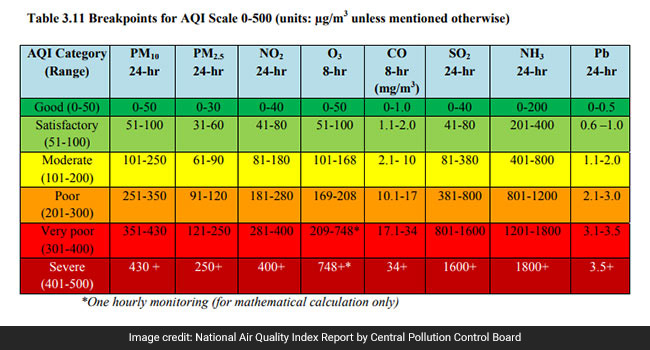

# PM 2.5

In [ ]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

df["PM2.5_SubIndex"] = df["PM2.5_24hr_avg"].apply(lambda x: get_PM25_subindex(x))

# PM 10

In [ ]:


## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        #return x * 50/ 50
        return x
    elif x <= 100:
        #return  50 + (x -  50) *  50 / 50
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

df["PM10_SubIndex"] = df["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))



# SO2

In [ ]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

df["SO2_SubIndex"] = df["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))


# NOx

In [ ]:
## NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

df["NOx_SubIndex"] = df["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))


# NH3

In [ ]:
## NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

df["NH3_SubIndex"] = df["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))


# CO

In [ ]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

df["CO_SubIndex"] = df["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))

# O3

In [ ]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

df["O3_SubIndex"] = df["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))

# step3
* Now that all the sub indices are calculated  it's time to find the overall AQI index
* The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

In [ ]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

df["Checks"] = (df["PM2.5_SubIndex"] > 0).astype(int) + \
                (df["PM10_SubIndex"] > 0).astype(int) + \
                (df["SO2_SubIndex"] > 0).astype(int) + \
                (df["NOx_SubIndex"] > 0).astype(int) + \
                (df["NH3_SubIndex"] > 0).astype(int) + \
                (df["CO_SubIndex"] > 0).astype(int) + \
                (df["O3_SubIndex"] > 0).astype(int)

df["AQI_calculated"] = round(df[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOx_SubIndex",
                                 "NH3_SubIndex", "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
df.loc[df["PM2.5_SubIndex"] + df["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
df.loc[df.Checks < 3, "AQI_calculated"] = np.NaN

df["AQI_bucket_calculated"] = df["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
df[~df.AQI_calculated.isna()].head(13)

In [ ]:
df[~df.AQI_calculated.isna()].AQI_bucket_calculated.value_counts()

In [ ]:
df1 = df

In [ ]:
df_check_station_hour = df1[["AQI", "AQI_calculated"]].dropna()
print("Station + Hour")
print("Rows: ", df_check_station_hour.shape[0])
print("Matched AQI: ", (df_check_station_hour.AQI == df_check_station_hour.AQI_calculated).sum())
print("% Match: ", (df_check_station_hour.AQI == df_check_station_hour.AQI_calculated).sum() * 100 / df_check_station_hour.shape[0])